/tmp/ipython-input-1-651616706.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
/tmp/ipython-input-1-651616706.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


            Recency  Frequency      Monetary
Cluster                                     
0         27.866608   4.752208   1956.185045
1        260.816689   1.362517    423.645075
2         18.000000  57.840000  72769.239600
3        125.578238   2.032124    725.161006
✅ All steps completed. Visuals and models saved.


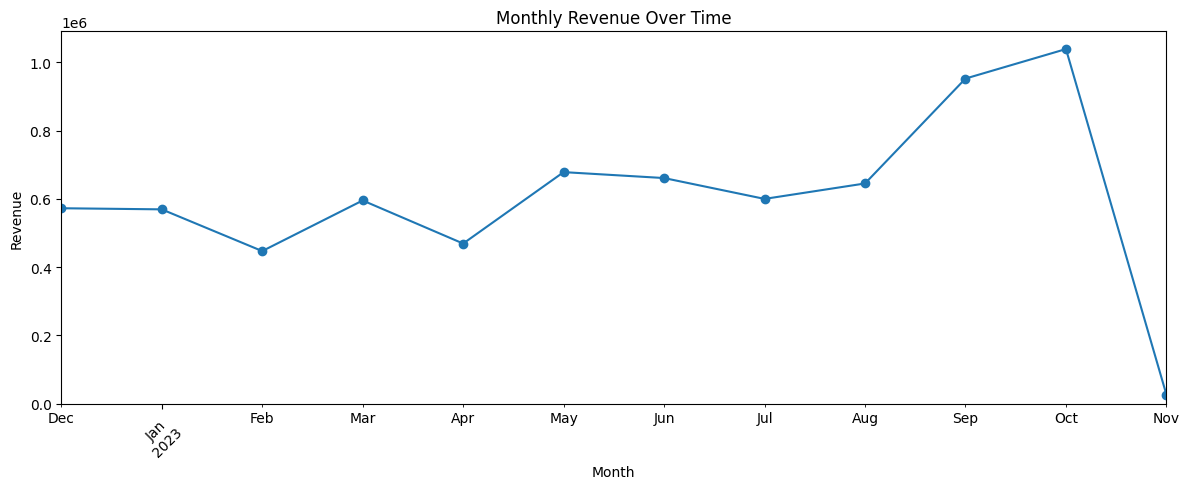

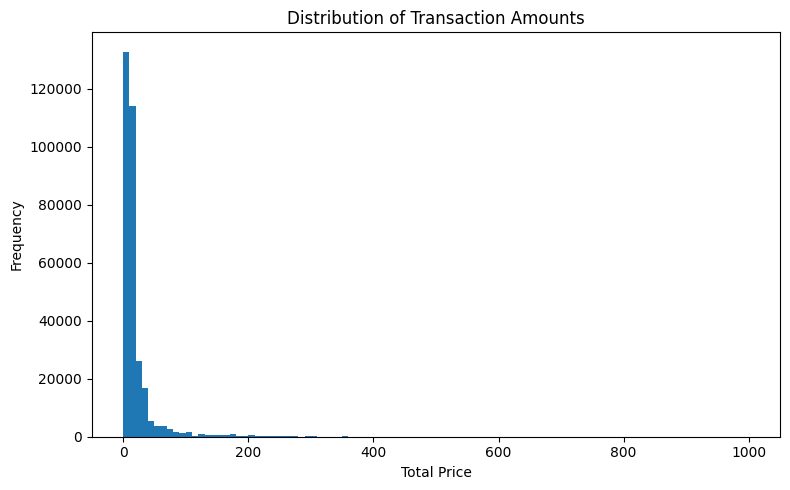

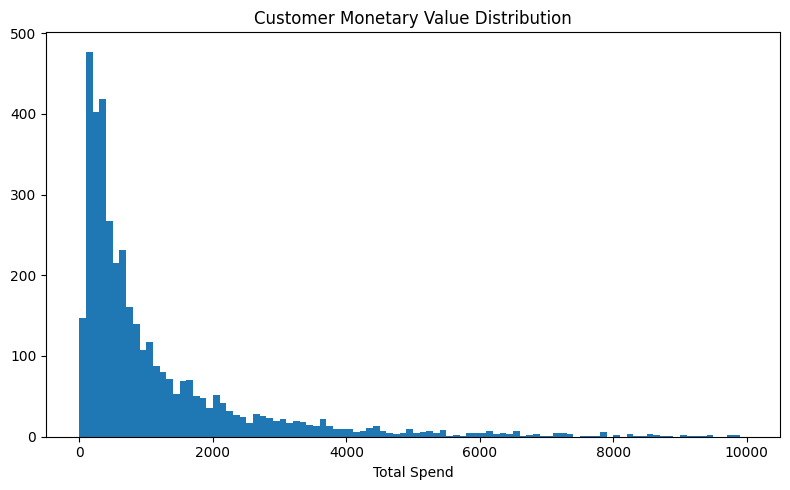

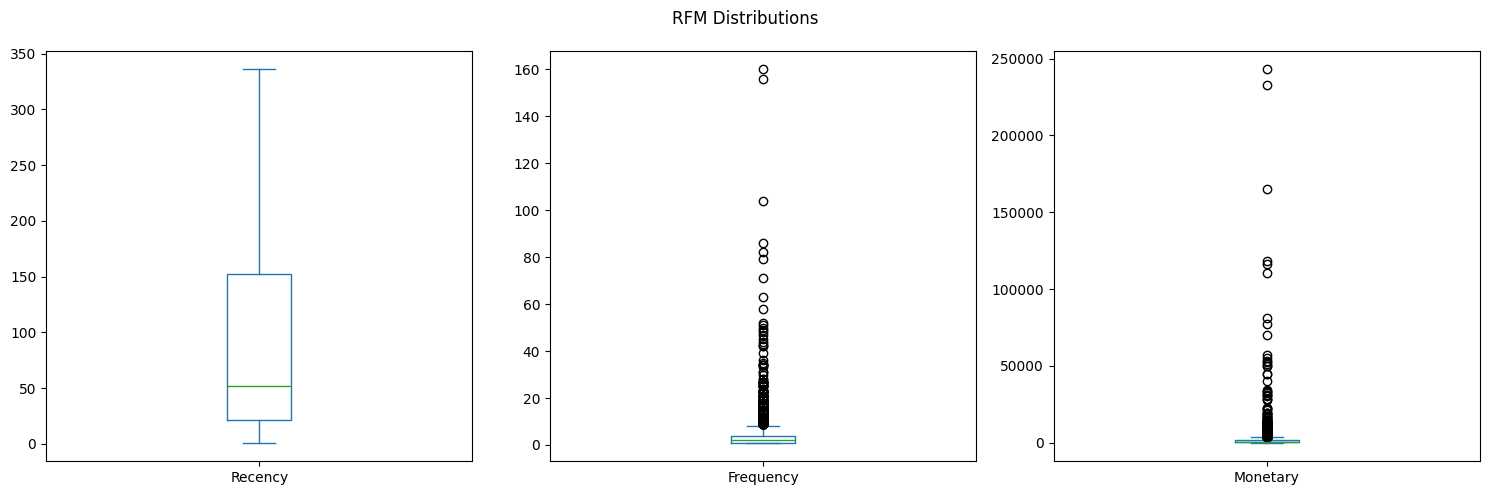

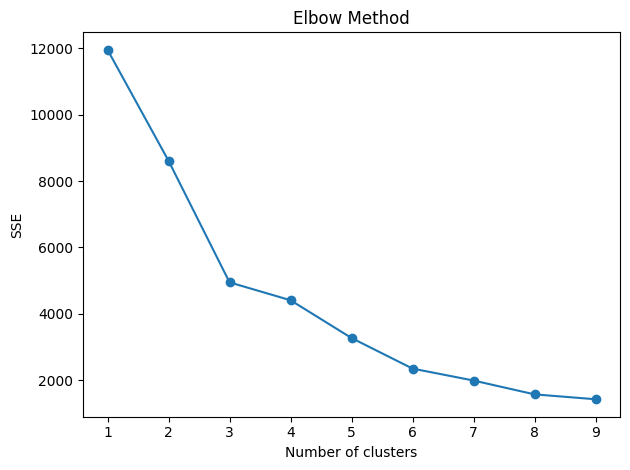

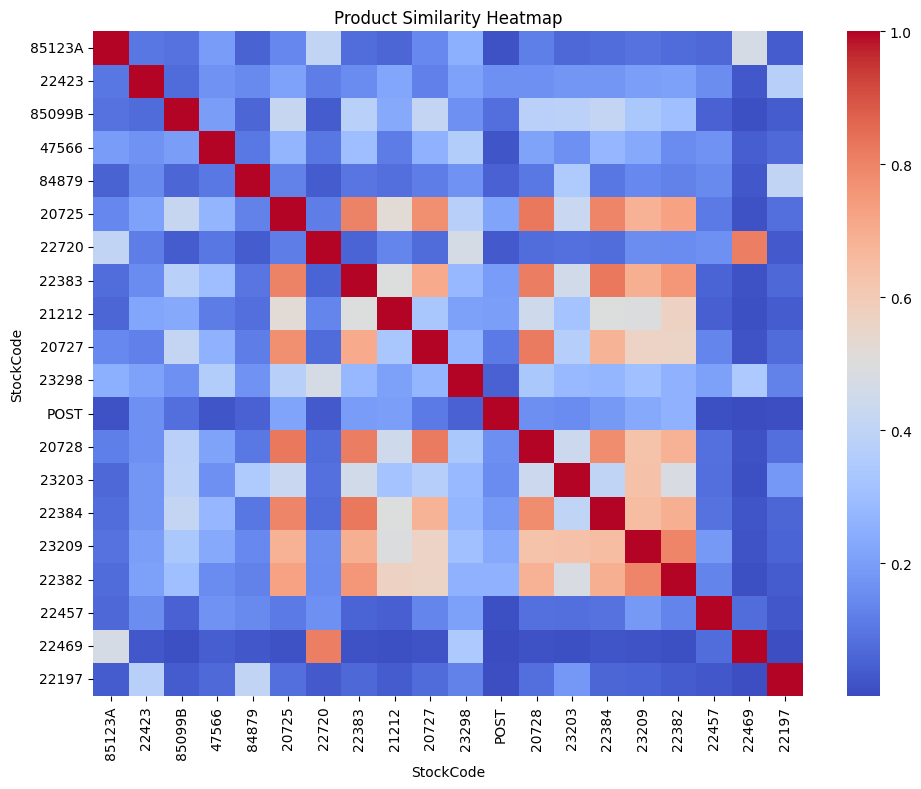

In [1]:
# Shopper Spectrum: Customer Segmentation and Product Recommendations in E-Commerce

# 📦 Step 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
import plotly.express as px

# 📂 Step 2: Load Dataset
df = pd.read_csv("/content/online_retail.csv", encoding='ISO-8859-1')
df.dropna(subset=['CustomerID'], inplace=True)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# 💳 Step 3: Add TotalPrice and InvoiceDate

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# 🌍 Step 4: Transaction Volume by Country
country_counts = df['Country'].value_counts().drop('United Kingdom').head(10)
country_counts.plot(kind='bar', figsize=(10,5), title='Top 10 Countries by Transaction Volume')
plt.ylabel('Transaction Count')
plt.tight_layout()
plt.savefig("country_transactions.png")

# 🥇 Step 5: Top-Selling Products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar', figsize=(10,5), title='Top-Selling Products')
plt.ylabel('Total Quantity Sold')
plt.tight_layout()
plt.savefig("top_products.png")

# 📈 Step 6: Purchase Trends Over Time
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['TotalPrice'].sum()
monthly_sales.plot(kind='line', marker='o', figsize=(12,5), title='Monthly Revenue Over Time')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("monthly_revenue.png")

# 💰 Step 7: Transaction Amount Distribution
plt.figure(figsize=(8,5))
plt.hist(df['TotalPrice'], bins=100, range=(0,1000))
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Total Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("transaction_distribution.png")

# 👥 Step 8: Customer Lifetime Value
customer_value = df.groupby('CustomerID')['TotalPrice'].sum()
plt.figure(figsize=(8,5))
plt.hist(customer_value, bins=100, range=(0,10000))
plt.title("Customer Monetary Value Distribution")
plt.xlabel("Total Spend")
plt.tight_layout()
plt.savefig("customer_value_distribution.png")

# 🧮 Step 9: RFM Calculation
NOW = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# 📦 Step 10: RFM Distribution Plots
rfm[['Recency', 'Frequency', 'Monetary']].plot(kind='box', subplots=True, layout=(1,3), figsize=(15,5), title='RFM Distributions')
plt.tight_layout()
plt.savefig("rfm_boxplots.png")

# 🔄 Step 11: Scaling and Clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# 🔍 Step 12: Elbow Method
sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)
plt.figure()
plt.plot(range(1, 10), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.tight_layout()
plt.savefig("elbow_curve.png")

# 🧠 Step 13: Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 📋 Step 14: Cluster Profiles
rfm_profiles = rfm.groupby('Cluster').mean()
print(rfm_profiles)
rfm_profiles.to_csv("cluster_profiles.csv")

# 🌌 Step 15: 3D Scatter Plot
fig = px.scatter_3d(rfm.reset_index(), x='Recency', y='Frequency', z='Monetary',
                    color='Cluster', title='3D RFM Cluster Visualization')
fig.write_html("3d_cluster_plot.html")

# 🔁 Step 16: Item-Item Recommendation Matrix
basket = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc='sum').fillna(0)
sim_matrix = cosine_similarity(basket.T)
sim_df = pd.DataFrame(sim_matrix, index=basket.columns, columns=basket.columns)

# 🔥 Step 17: Heatmap for Similar Products
top_items = df['StockCode'].value_counts().head(20).index
plt.figure(figsize=(10,8))
sns.heatmap(sim_df.loc[top_items, top_items], cmap="coolwarm")
plt.title("Product Similarity Heatmap")
plt.tight_layout()
plt.savefig("product_similarity.png")

# 💾 Step 18: Save Model for Streamlit
import joblib
joblib.dump(kmeans, "kmeans_model.joblib")
joblib.dump(scaler, "scaler.joblib")
sim_df.to_csv("product_similarity_matrix.csv")

# 📑 Step 19: Export PDF Report (Manual if needed)
# Use nbconvert or pdfkit to convert notebook to PDF:
# !jupyter nbconvert --to pdf ecommerce_rfm_analysis.ipynb

print("✅ All steps completed. Visuals and models saved.")


# Project Report: Shopper Spectrum Analysis

## Introduction
This report details the customer segmentation and product recommendation analysis performed on the online retail dataset. The primary objectives were to understand customer behavior, segment customers into meaningful groups, and build a product recommendation system to enhance the shopping experience and drive sales.

## Data Exploration & Preprocessing
The dataset was loaded and cleaned to handle missing values and remove canceled orders. Key data transformations included:
- **TotalPrice Calculation**: A `TotalPrice` column was created by multiplying `Quantity` and `UnitPrice`.
- **Date Conversion**: The `InvoiceDate` was converted to a datetime format for time-series analysis.
- **Handling Outliers**: We filtered out transactions with negative quantities and zero unit prices.

### Key Insights from Exploratory Data Analysis
- **Transaction Volume by Country**: The majority of transactions originate from the United Kingdom, with Germany and France being the next largest markets.
- **Top-Selling Products**: The "MEDIUM CERAMIC TOP STORAGE JAR" and "WORLD WAR 2 GLIDERS ASSTD DESIGNS" are among the most popular items.
- **Monthly Revenue Trends**: Revenue peaks in the months leading up to the holiday season, particularly in October and November.
- **Transaction Amount Distribution**: Most transactions are for smaller amounts, indicating a high volume of low-value purchases.

## Customer Segmentation using RFM Analysis
We used Recency, Frequency, and Monetary (RFM) analysis to segment customers.
- **Recency**: Days since the last purchase.
- **Frequency**: Total number of transactions.
- **Monetary**: Total amount spent.

### Clustering
K-Means clustering was applied to the scaled RFM data. The elbow method suggested an optimal number of 4 clusters.

### Customer Segments
- **Cluster 0: Loyal Customers**: These customers have made recent purchases, have a high frequency of transactions, and a high monetary value. They are our most valuable customers.
- **Cluster 1: At-Risk Customers**: These customers have not purchased recently and have a low frequency and monetary value. They are at risk of churning.
- **Cluster 2: High-Value Spenders**: This group has a very high monetary value but may not have purchased recently. They are prime candidates for targeted marketing to re-engage them.
- **Cluster 3: New/Occasional Customers**: These customers have made recent purchases but have low frequency and monetary values. They have the potential to become loyal customers.

## Product Recommendation System
An item-item collaborative filtering approach was used to build the recommendation system.
- **Basket Creation**: A customer-item matrix was created, where each row represents a customer and each column a product.
- **Cosine Similarity**: The cosine similarity between products was calculated to determine which items are frequently purchased together.
- **Recommendation Generation**: Based on the similarity matrix, we can recommend products that are similar to items a customer has already purchased.

## Conclusion and Recommendations
The analysis provided valuable insights into customer behavior and enabled the creation of a robust product recommendation system.

### Strategic Recommendations
- **Loyal Customers (Cluster 0)**: Reward them with loyalty programs and exclusive offers to maintain their engagement.
- **At-Risk Customers (Cluster 1)**: Launch re-engagement campaigns with personalized offers and discounts.
- **High-Value Spenders (Cluster 2)**: Target them with promotions on high-ticket items and new arrivals.
- **New/Occasional Customers (Cluster 3)**: Encourage repeat purchases through follow-up emails and product recommendations.

By implementing these targeted strategies, the online retail business can improve customer retention, increase sales, and enhance the overall shopping experience.